This code 
- defines a logistic regression model to classify 41 diseases
- finds top-5 symptoms with feature importance analysis
- finds top-5 symptoms with recursive feature elimination
- plots top n important symptoms for a disease

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Loading training dataset
disease_df_train = pd.read_csv('../data/processed/Training.csv')
X_train = disease_df_train.drop(columns=['prognosis'])
y_train = disease_df_train['prognosis']

# Loading testing dataset
disease_df_test = pd.read_csv('../data/processed/Testing.csv')
X_test = disease_df_test.drop(columns=['prognosis'])
y_test = disease_df_test['prognosis']

# Encoding labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Initializing Logistic Regression model
log_reg = LogisticRegression(solver='lbfgs', max_iter=100, random_state=42)

# Performing 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")

# Training the model on the full training set
log_reg.fit(X_train, y_train)

# # Evaluation on the test set
# test_accuracy = log_reg.score(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy:.2f}")

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.00


LogisticRegression(random_state=42)

Getting a set of 5 most important symptoms with Feature Importance

In [17]:
#import numpy as np
import pandas as pd

# Getting coefficients from the model
# Shape: (num_diseases, num_symptoms)
coefficients = log_reg.coef_

# Getting symptom names
symptoms = X_train.columns  # Feature names

# Creating a DataFrame to store the coefficients and symptoms
coef_df = pd.DataFrame(coefficients, columns=symptoms)

# Definining a function to get the top k symptoms for a disease
def get_top_k_symptoms_for_disease(disease_idx, top_k=5):
    disease_coeffs = coef_df.iloc[disease_idx].abs()  # Take absolute value for importance
    top_symptoms = disease_coeffs.sort_values(ascending=False).head(top_k)
    return top_symptoms

# Getting the top 5 symptoms for each disease
top_k = 5
minimal_sets = {}

# Looping through all diseases to get top symptoms
for disease_idx in range(coefficients.shape[0]):
    disease_name = label_encoder.classes_[disease_idx]  # Get the disease name
    top_symptoms = get_top_k_symptoms_for_disease(disease_idx, top_k)
    
    # Printing the disease and its top symptoms with their coefficients
    print(f"Top {top_k} symptoms for {disease_name}:")
    for symptom, coef in top_symptoms.items():
        print(f"{symptom}: {coef:.4f}")
    print("\n" + "-"*40)  # Separator between diseases

Top 5 symptoms for (vertigo) Paroymsal  Positional Vertigo:
unsteadiness: 1.9528
spinning_movements: 1.7352
loss_of_balance: 1.6509
nausea: 1.3946
headache: 1.1171

----------------------------------------
Top 5 symptoms for AIDS:
extra_marital_contacts: 1.9648
muscle_wasting: 1.9648
patches_in_throat: 1.9648
high_fever: 1.5866
vomiting: 0.6281

----------------------------------------
Top 5 symptoms for Acne:
scurring: 2.0636
blackheads: 2.0636
pus_filled_pimples: 2.0636
skin_rash: 1.5162
itching: 0.5140

----------------------------------------
Top 5 symptoms for Alcoholic hepatitis:
distention_of_abdomen: 1.7748
history_of_alcohol_consumption: 1.7748
swelling_of_stomach: 1.7748
yellowish_skin: 1.2463
abdominal_pain: 1.1350

----------------------------------------
Top 5 symptoms for Allergy:
shivering: 1.9224
watering_from_eyes: 1.9224
continuous_sneezing: 1.8620
chills: 1.7137
vomiting: 0.6240

----------------------------------------
Top 5 symptoms for Arthritis:
movement_stiffnes

On coefficients: a small coefficient in the model doesn't necessarily mean the feature isn't important. It could indicate that the feature is redundant or correlated with other features in the model.

On getting minimal symptom set from coefficients: Feature Importance from coefficients assumes independence between features, measures the direct impact of each feature on the target variable, and cannot capture interactions between features; assumes that each symptom affects the disease independently. 

RFE - iteratively remove less important symptoms until only the specified number of features (e.g., top 5 symptoms) remain. It can be applied to each disease independently, focusing on finding the most impactful symptoms for each specific disease. RFE does account for interactions between symptoms, even though it doesn't explicitly model those interactions. When features are removed, the model is retrained without them, which means the interactions between the remaining features will be reevaluated in a new context. When certain features (symptoms) are removed, the model has to adjust its understanding of how the remaining features interact and how they contribute to predicting the target (disease). So, removing one symptom might change the importance of other symptoms by altering their perceived interactions in the context of the disease classification.

Getting a set of 5 most important symptoms with Recursive Feature Elimination

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#import pandas as pd

diseases = label_encoder.classes_

# Creating an empty dictionary to store top features for each disease
top_features_per_disease = {}

# Looping over each disease and apply RFE
for disease_idx, disease in enumerate(diseases):
    # Create the binary labels for the current disease (1 for the disease, 0 for others)
    y_train_binary = (y_train == disease_idx).astype(int)
    
    # Creating a logistic regression model
    log_reg_model = LogisticRegression(max_iter=5000)
    
    # Applying RFE to the logistic regression model
    selector = RFE(log_reg_model, n_features_to_select=5)  # Select top 5 features
    selector = selector.fit(X_train, y_train_binary)
    
    # Getting the indices of the selected features
    selected_feature_indices = selector.support_  # Boolean mask of selected features
    
    # Getting the names of the top features
    top_features = X_train.columns[selected_feature_indices]
    
    # Storing the top features for this disease
    top_features_per_disease[disease] = top_features

# Now `top_features_per_disease` contains the top 5 features for each disease
print(top_features_per_disease)

{'(vertigo) Paroymsal  Positional Vertigo': Index(['vomiting', 'nausea', 'spinning_movements', 'loss_of_balance',
       'unsteadiness'],
      dtype='object'), 'AIDS': Index(['muscle_wasting', 'fatigue', 'patches_in_throat', 'high_fever',
       'extra_marital_contacts'],
      dtype='object'), 'Acne': Index(['skin_rash', 'fatigue', 'pus_filled_pimples', 'blackheads', 'scurring'], dtype='object'), 'Alcoholic hepatitis': Index(['yellowish_skin', 'abdominal_pain', 'swelling_of_stomach',
       'distention_of_abdomen', 'history_of_alcohol_consumption'],
      dtype='object'), 'Allergy': Index(['continuous_sneezing', 'shivering', 'chills', 'high_fever',
       'watering_from_eyes'],
      dtype='object'), 'Arthritis': Index(['muscle_weakness', 'stiff_neck', 'swelling_joints',
       'movement_stiffness', 'painful_walking'],
      dtype='object'), 'Bronchial Asthma': Index(['cough', 'breathlessness', 'chest_pain', 'family_history',
       'mucoid_sputum'],
      dtype='object'), 'Cervical 

Feature Importance and RFE results combined

In [19]:
#import pandas as pd

# Initializing lists to store results
feature_importance_results = []
rfe_results = []

# 1: Feature importance (from logistic regression coefficients)
for disease_idx in range(coefficients.shape[0]):
    disease_name = label_encoder.classes_[disease_idx]  # Get the disease name
    top_symptoms = get_top_k_symptoms_for_disease(disease_idx, top_k)
    
    # Collecting the feature importance results
    top_symptoms_dict = {'Disease': disease_name}
    for idx, (symptom, coef) in enumerate(top_symptoms.items()):
        top_symptoms_dict[f'Feature Importance {idx+1}'] = symptom
        top_symptoms_dict[f'Coefficient {idx+1}'] = coef
    
    feature_importance_results.append(top_symptoms_dict)

# 2: RFE results
for disease_name, top_rfe_features in top_features_per_disease.items():
    # Collecting the RFE results
    rfe_dict = {'Disease': disease_name}
    for idx, symptom in enumerate(top_rfe_features):
        rfe_dict[f'RFE Feature {idx+1}'] = symptom
    
    rfe_results.append(rfe_dict)

# 3: Combining results into a single DataFrame
feature_importance_df = pd.DataFrame(feature_importance_results)
rfe_df = pd.DataFrame(rfe_results)

# Merging the two DataFrames on the 'Disease' column
combined_df = pd.merge(feature_importance_df, rfe_df, on='Disease', how='outer')

# 4: Printing the results side by side
combined_df.head(2)

,Disease,Feature Importance 1,Coefficient 1,Feature Importance 2,Coefficient 2,Feature Importance 3,Coefficient 3,Feature Importance 4,Coefficient 4,Feature Importance 5,Coefficient 5,RFE Feature 1,RFE Feature 2,RFE Feature 3,RFE Feature 4,RFE Feature 5
0,(vertigo) Paroymsal Positional Vertigo,unsteadiness,1.952751,spinning_movements,1.735212,loss_of_balance,1.650943,nausea,1.394649,headache,1.117139,vomiting,nausea,spinning_movements,loss_of_balance,unsteadiness
1,AIDS,extra_marital_contacts,1.964811,muscle_wasting,1.964811,patches_in_throat,1.964811,high_fever,1.586586,vomiting,0.628091,muscle_wasting,fatigue,patches_in_throat,high_fever,extra_marital_contacts


In [20]:
combined_df.loc[10]

Disease                       Common Cold
Feature Importance 1      redness_of_eyes
Coefficient 1                    0.788301
Feature Importance 2           congestion
Coefficient 2                    0.788301
Feature Importance 3    throat_irritation
Coefficient 3                    0.788301
Feature Importance 4       sinus_pressure
Coefficient 4                    0.788301
Feature Importance 5        loss_of_smell
Coefficient 5                    0.788301
RFE Feature 1             redness_of_eyes
RFE Feature 2              sinus_pressure
RFE Feature 3                  runny_nose
RFE Feature 4                  congestion
RFE Feature 5               loss_of_smell
Name: 10, dtype: object


Feature importance plot for a selected disease

In [28]:
combined_df["Disease"]

0     (vertigo) Paroymsal  Positional Vertigo
1                                        AIDS
2                                        Acne
3                         Alcoholic hepatitis
4                                     Allergy
5                                   Arthritis
6                            Bronchial Asthma
7                        Cervical spondylosis
8                                 Chicken pox
9                         Chronic cholestasis
10                                Common Cold
11                                     Dengue
12                                  Diabetes 
13               Dimorphic hemmorhoids(piles)
14                              Drug Reaction
15                           Fungal infection
16                                       GERD
17                            Gastroenteritis
18                               Heart attack
19                                Hepatitis B
20                                Hepatitis C
21                                

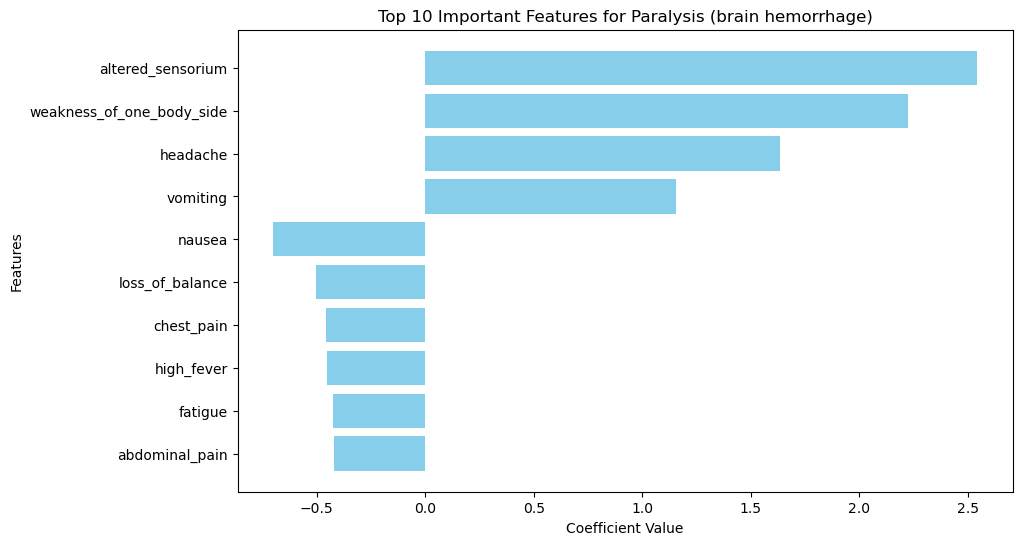

In [21]:
import matplotlib.pyplot as plt
#import pandas as pd

# Selecting the disease index and name
disease_idx = 32  # Replace with the index of the disease you want to analyze
disease_name = label_encoder.classes_[disease_idx]

# Getting the coefficients for the selected disease
disease_coefficients = log_reg.coef_[disease_idx]

# Creating a DataFrame for better sorting and visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': disease_coefficients
})

# Sorting features by absolute importance
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plotting the top 10 most important features
top_features = feature_importance_df.head(10)
# top_features = feature_importance_df # All coefficients

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title(f'Top 10 Important Features for {disease_name}')
plt.gca().invert_yaxis()  # Inverting y-axis for better readability
plt.show()